### NWB User days
Goals:
* Converting raw data to NWB 
* Preprocess data with SpikeInterface
* Spike sort with SpikeInterface
* Wrapping functions and approach into a github package

### Using wrapper functions to read and/or write .ncs data into .nwb

In [11]:
# This package is for reading nwb data easily
from decode_lab_code.decode_converters.ephys.nlx2nwb import interfaceNLX

# read or write?
dataCommand = 'read'

# lets get our path with data
folder_name = '/Users/js0403/Sample-data'

# pull in data - this would be the data freely shared!
if dataCommand == 'read':
    print("reading nwb data")
    data_nwb = interfaceNLX.readNWB(folder_name,'data_nwb')
elif dataCommand == 'write':
    # write data
    print("Writing data...")
    interfaceNLX.writeNWB(fileName='data_nwb')
    print("Reading data...")
    data_nwb = interfaceNLX.readNWB(folder_name,'data_nwb')

reading nwb data


In [6]:
import nwbwidgets
nwbwidgets.nwb2widget(data_nwb)

### SpikeInterface
* extract converted neural data
* remove channels not used for spike sorting

In [12]:
# The spikeinterface module by itself imports only the spikeinterface.core submodule
# which is not useful for end user
import matplotlib.pyplot as plt
from pprint import pprint
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from warnings import simplefilter
simplefilter("ignore")

# working with this code: 
# https://github.com/NeurodataWithoutBorders/nwb_hackathons/blob/main/Cosyne_2023/tutorials/spikeinterface_tutorial.ipynb

# Before getting started, we can set some global arguments for parallel processing. For this example, let's use 4 jobs and time chunks of 1s:
global_job_kwargs = dict(n_jobs=4, chunk_duration="1s")
si.set_global_job_kwargs(**global_job_kwargs)

# read nwb data and set it to "recording_nwb" object
recording_nwb = se.read_nwb_recording(file_path=folder_name+'/data_nwb')

# we want to let the recording_nwb "extractor" know that the data has not been filtered. This will prevent
# mistakes in the pipeline, like extracting waveforms from unfiltered data
recording_nwb.annotate(is_filtered=False)
se.recording_extractor_full_dict

# A RecordingExtractor object extracts information about channel IDs, channel locations (if present),
# the sampling frequency of the recording, and the extracellular traces (when prompted). 
channel_ids = recording_nwb.get_channel_ids() # treating it like a function, rather than an attribut (check my facts)
fs = recording_nwb.get_sampling_frequency()
num_chan = recording_nwb.get_num_channels()
num_segments = recording_nwb.get_num_segments()

print(f'Channel ids: {channel_ids}')
print(f'Sampling frequency: {fs}')
print(f'Number of channels: {num_chan}')
print(f"Number of segments: {num_segments}")

trace_snippet = recording_nwb.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))
print('Traces shape:', trace_snippet.shape)

# -- properties -- #
print("Properties:\n", list(recording_nwb.get_property_keys()))

# remove CSC data for clustering spikes
from probeinterface import generate_tetrode, ProbeGroup
remData = []
for chi in range(len(channel_ids)):
    if 'CSC' in channel_ids[chi]:
        remData.append(chi)
remData = np.array(remData)
# remove CSC
tt_nwb = recording_nwb.remove_channels(channel_ids[remData])
print(tt_nwb.get_channel_ids())

Channel ids: ['CSC1' 'CSC2' 'CSC3' 'CSC4' 'TT1a' 'TT1b' 'TT1c' 'TT1d' 'TT2a' 'TT2b'
 'TT2c' 'TT2d' 'TT3a' 'TT3b' 'TT3c' 'TT3d' 'TT4a' 'TT4b' 'TT4c' 'TT4d']
Sampling frequency: 32000.0
Number of channels: 20
Number of segments: 1
Traces shape: (64000, 20)
Properties:
 ['gain_to_uV', 'offset_to_uV', 'brain_area', 'group', 'channel_name', 'DspLowCutFilterType', 'FileType', 'DSPHighCutFilterEnabled', 'NumADChannels', 'channel_ids', 'DspLowCutFrequency', 'input_inverted', 'recording_opened', 'RecordSize', 'ADMaxValue', 'DspHighCutFilterType', 'recording_closed', 'DspLowCutNumTaps', 'DspHighCutFrequency', 'DSPLowCutFilterEnabled', 'DspDelayCompensation', 'channel_names', 'DspFilterDelay_µs', 'DspHighCutNumTaps']
['TT1a' 'TT1b' 'TT1c' 'TT1d' 'TT2a' 'TT2b' 'TT2c' 'TT2d' 'TT3a' 'TT3b'
 'TT3c' 'TT3d' 'TT4a' 'TT4b' 'TT4c' 'TT4d']


### SpikeInterface
* preprocess the data

[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


(-1000.0, 1200.0)

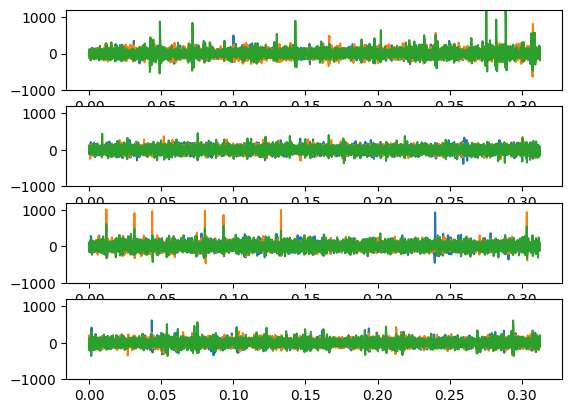

In [8]:
# generate tetrode
tt_ids = tt_nwb.get_channel_ids() # get IDs
tt_count = int(len(tt_ids)/4) # group data into tetrode
probeGroup = ProbeGroup() # create a "ProbeGroup"
for i in range(tt_count):
    tt = generate_tetrode()
    tt.set_device_channel_indices(np.arange(tt_count) + i * 4)
    probeGroup.add_probe(tt)
tt_grouped = tt_nwb.set_probegroup(probeGroup, group_mode='by_probe')
print(tt_grouped.get_channel_groups())
print(tt_grouped.get_property('group'))

# lets filter our data
from spikeinterface.preprocessing import bandpass_filter, common_reference
bp_low = 500; bp_high = 9000
tt_filt = bandpass_filter(tt_grouped, freq_min=bp_low, freq_max=bp_high)
tt_cmr = common_reference(tt_filt, operator="median") # can also use average

# how can we visualize our progress?
chI = 0
exData = recording_nwb.get_traces(chI,start_frame = 0, end_frame = 32000)
exFilt = tt_filt.get_traces(chI,start_frame = 0, end_frame = 32000)
exCMR  = tt_cmr.get_traces(chI,start_frame = 0, end_frame = 32000)
plt.plot(exData[:,0],color='k')
plt.plot(exFilt[:,0],color='b')
plt.plot(exCMR[:,0],color='r')

# make subplots showing each tt
xData = np.linspace(0,10000/32000,10000)
plt.subplot(4,1,1)
plt.plot(xData,exCMR[0:10000,0:3])
plt.ylim((-1000,1200))
plt.subplot(4,1,2)
plt.plot(xData,exCMR[0:10000,4:7])
plt.ylim((-1000,1200))
plt.subplot(4,1,3)
plt.plot(xData,exCMR[0:10000,8:11])
plt.ylim((-1000,1200))
plt.subplot(4,1,4)
plt.plot(xData,exCMR[0:10000,12:15])
plt.ylim((-1000,1200))

### SpikeInterface
* Sorting

In [9]:
# continue on...
folderSave = folder_name+'/tt_processed'
recording_preprocessed = tt_cmr.save(format='binary',folder=folderSave)
print(recording_preprocessed)

# TTs: MountainSort4 is best, spyKingCircus does well, IronClust does well

# lets print our available sorters
print('Available sorters', ss.available_sorters())
print('Installed sorters', ss.installed_sorters())

# Print the parameters and adjust them
print("Tridesclous params:")
pprint(ss.get_default_sorter_params('tridesclous'))
print("SpykingCircus2 params:")
pprint(ss.get_default_sorter_params('spykingcircus2'))

AssertionError: folder /Users/js0403/Sample-data/tt_processed already exists, choose another name